 Cardiovascular Disease Diagnosis model

 Install / import libraries

In [2]:
!pip install -q scikit-learn pandas matplotlib seaborn

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

Download & load dataset (UCI Heart Disease - processed Cleveland)

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
cols = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','target']

df = pd.read_csv(url, header=None, names=cols)

print('Raw shape:', df.shape)
print('First rows:')
print(df.head())

Raw shape: (303, 14)
First rows:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  target  
0    3.0  0.0  6.0       0  
1    2.0  3.0  3.0       2  
2    2.0  2.0  7.0       1  
3    3.0  0.0  3.0       0  
4    1.0  0.0  3.0       0  


Clean / preprocess

In [4]:
# Replace ? with NaN, convert columns to numeric
df = df.replace('?', np.nan)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Target: 0 means no disease, 1-4 means disease. Convert to binary
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

# Quick statistics
print('\nMissing values per column:')
print(df.isna().sum())

# Impute missing values with median (simple approach)
for c in df.columns:
    if df[c].isna().sum() > 0:
        med = df[c].median()
        df[c] = df[c].fillna(med)
        print(f'Imputed {c} with median={med}')


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64
Imputed ca with median=0.0
Imputed thal with median=3.0


Feature engineering

In [5]:
# For simplicity use a basic set of features. Convert categorical-ish columns to dummies.
cat_cols = ['cp','restecg','slope','thal','ca','sex','fbs','exang']
num_cols = [c for c in df.columns if c not in cat_cols + ['target']]

X = pd.get_dummies(df.drop(columns=['target']), columns=cat_cols, drop_first=True)
y = df['target']

print('\nFeatures shape after dummies:', X.shape)

# Scale numeric features (only the original numeric columns)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


Features shape after dummies: (303, 20)


Train / test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Training samples:', X_train.shape[0], 'Test samples:', X_test.shape[0])

Training samples: 242 Test samples: 61


Train a simple model (Random Forest)

In [7]:
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

Evaluation


Accuracy: 0.8852459016393442

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



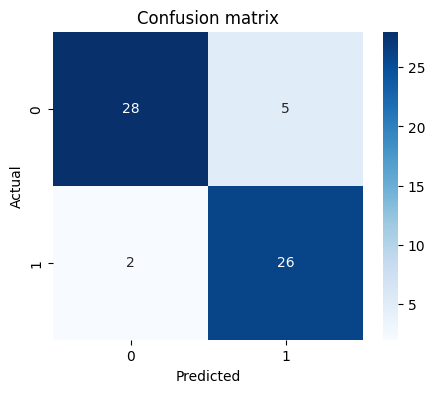


ROC AUC: 0.9361471861471862


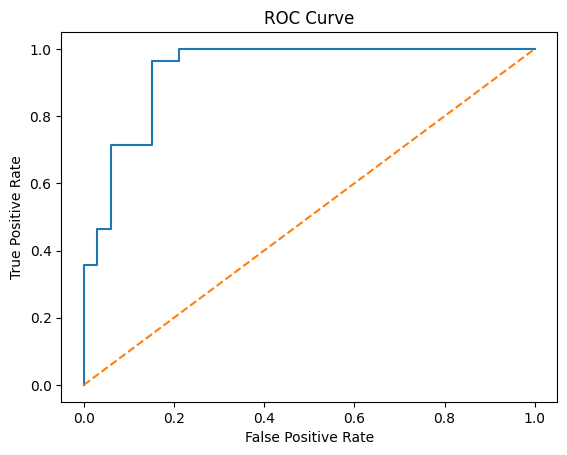

In [8]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print('\nAccuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

# ROC AUC
auc = roc_auc_score(y_test, y_proba)
print('\nROC AUC:', auc)

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Feature importance

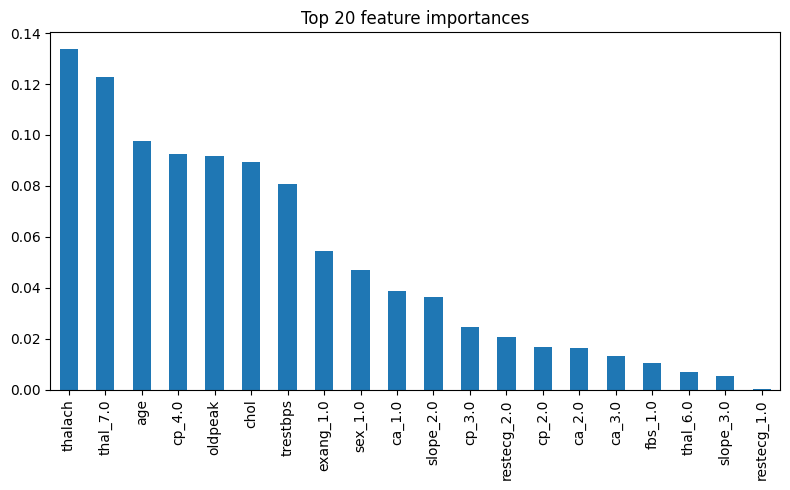

In [9]:
fi = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(8,5))
fi.plot(kind='bar')
plt.title('Top 20 feature importances')
plt.tight_layout()
plt.show()

Save model & scaler

In [10]:
import joblib
joblib.dump(clf, 'rf_cvd_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
print('Saved model to rf_cvd_model.joblib and scaler.joblib')

Saved model to rf_cvd_model.joblib and scaler.joblib


Quick prediction function example

In [11]:
# Provide a single-row example from the test set
example = X_test.iloc[0:1]
print('\nExample features (scaled/dummies):')
print(example)
print('\nPredicted probability of disease:', clf.predict_proba(example)[:,1])
print('Predicted label:', clf.predict(example)[0])


Example features (scaled/dummies):
          age  trestbps      chol   thalach   oldpeak  cp_2.0  cp_3.0  cp_4.0  \
219  0.505451  0.359134  0.470232  1.418418 -0.896862   False   False    True   

     restecg_1.0  restecg_2.0  slope_2.0  slope_3.0  thal_6.0  thal_7.0  \
219        False         True      False      False     False     False   

     ca_1.0  ca_2.0  ca_3.0  sex_1.0  fbs_1.0  exang_1.0  
219   False   False   False     True    False      False  

Predicted probability of disease: [0.41]
Predicted label: 0


In [12]:
from google.colab import files

files.download('rf_cvd_model.joblib')
files.download('scaler.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

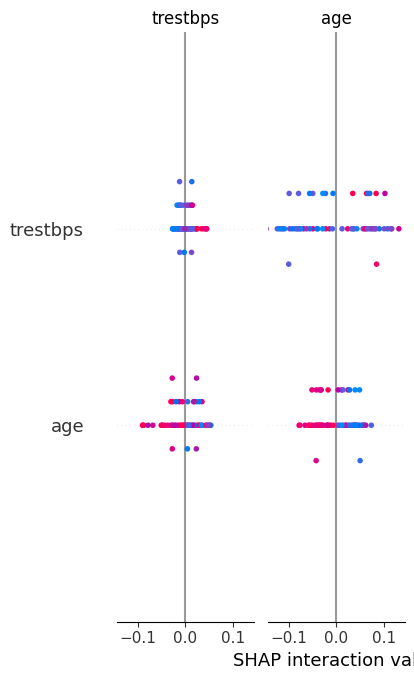

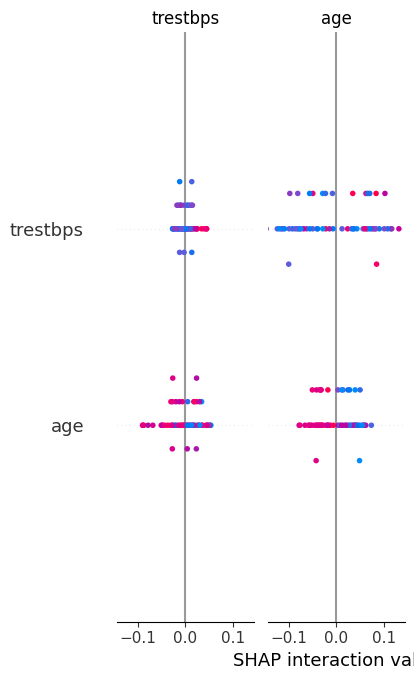

In [13]:
!pip install shap
import shap

# Convert to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Create explainer and compute SHAP values
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test, check_additivity=False)

# Summary plots
shap.summary_plot(shap_values, X_test, plot_type='bar')
shap.summary_plot(shap_values, X_test)




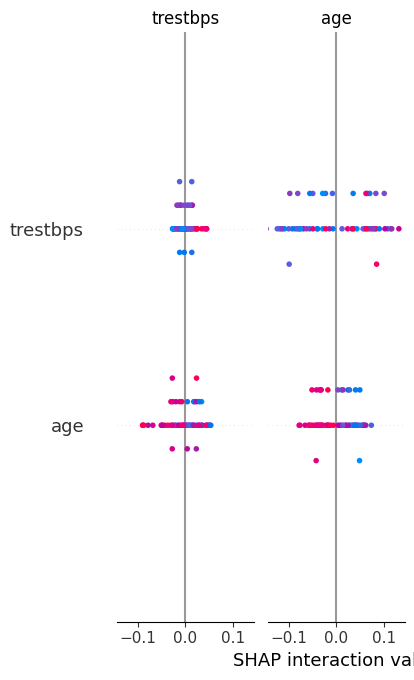

In [14]:
# --- Step 4: SHAP Summary (detailed view) ---
shap.summary_plot(shap_values, X_test)


In [15]:
# --- Step 5 (final fixed version for binary RandomForest models) ---
import shap
shap.initjs()

# Choose the patient
patient_index = 0

# Extract SHAP values for class 1 ("has disease")
# We use .values[..., 1] to get the positive class explanations
shap.plots.force(
    shap_values.base_values[patient_index, 1],  # base value for class 1
    shap_values.values[patient_index, :, 1],    # SHAP values for class 1
    X_test.iloc[patient_index, :]               # feature values
)



In [16]:
# Save as HTML to view interactively
shap.save_html(
    "patient_explanation.html",
    shap.plots.force(
        shap_values.base_values[patient_index, 1],
        shap_values.values[patient_index, :, 1],
        X_test.iloc[patient_index, :]
    )
)


In [17]:
from google.colab import files

files.download('patient_explanation.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# --- Step 7: Numerical Top 5 Feature Contributions ---

import numpy as np
import pandas as pd

patient_index = 0  # same patient you explained visually earlier

# Extract SHAP values for the "disease" class (class 1)
patient_shap = shap_values.values[patient_index, :, 1]

# Get feature names and SHAP contributions
feature_names = X_test.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Value': patient_shap,
    'Patient_Value': X_test.iloc[patient_index].values
})

# Sort by absolute impact
feature_importance['abs_val'] = feature_importance['SHAP_Value'].abs()
feature_importance = feature_importance.sort_values('abs_val', ascending=False)

# Show top 5 influential features
top5 = feature_importance.head(5)
print("\n🔍 Top 5 Features Influencing This Prediction:\n")
for i, row in top5.iterrows():
    direction = "↑ increases disease risk" if row.SHAP_Value > 0 else "↓ decreases disease risk"
    print(f"{row.Feature}: {row.Patient_Value:.3f} ({direction}, SHAP = {row.SHAP_Value:.3f})")

# Optional: show the DataFrame
top5[['Feature', 'Patient_Value', 'SHAP_Value']]




🔍 Top 5 Features Influencing This Prediction:

thal_7.0: 0.000 (↓ decreases disease risk, SHAP = -0.089)
age: 0.505 (↑ increases disease risk, SHAP = 0.078)
thalach: 1.418 (↓ decreases disease risk, SHAP = -0.069)
cp_4.0: 1.000 (↑ increases disease risk, SHAP = 0.054)
ca_1.0: 0.000 (↓ decreases disease risk, SHAP = -0.035)


,Feature,Patient_Value,SHAP_Value
13,thal_7.0,0.000000,-0.089400
0,age,0.505451,0.078272
3,thalach,1.418418,-0.068651
7,cp_4.0,1.000000,0.054491
14,ca_1.0,0.000000,-0.035454
